# Polymath again and differently

+ Research at the intersection of *Internal/External divide* and *Foundations and Practice* areas of this project.

+ *Officially* part of modelling of mathematical practice and problem-solving network, but I'd rather think of it as a formal as well as data-driven study of mathematical communities and interaction.

+ Research started last year, but it is a continuation of earlier work with Bart and Jean Paul.

+ Used scientific Python tools (`pandas`, `networkx`, `BeautifullSoup`, `matplotlib` and `Seaborn`) to study the interaction on the Polymath-blogs.

+ The bulk of the progress was only made in the last 6 months, and I'm still working on it.

<img src="PolymathProgress.png">

## Why digg once more into Polymath?

+ Prior work exists, but it remains inconclusive (descriptions without much "insight" that could inform philosophical projects

+ Still active and growing...
    + Polymath 10 on the "Erdos-Rado Sunflower problem" (Gil Kalai) started in November 2015.
    + Polymath 11 on "Frankl’s union-closed conjecture" (Gowers) officially started less than two weeks ago (grrr...)

+ Large repository of mathmatics in action *and* reflections on the project itself.

+ Usefull data to start from if we want to model mathematical practices.

+ We now know a lot more about e-research, and the study of online communities.

+ Study Polymath as a research-community.

## Interesting synergies between fields of study

### Content

+ Philosophy of mathematical practice

+ Social epistemology and the study of scientific communities

+ Sociology of e-research

### Methodology

+ Computational social-science

+ Formal models of interaction

### Two types of interaction

+ Data as starting point for formal modelling.

+ Formal insights as theory to inform network-analysis and other types of data-driven analysis.

## "Small data," lots of pictures...

In [1]:
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain, product
import json
import networkx as nx
import pandas as pd
from pandas import DataFrame
from urllib.parse import urlparse
import datetime

from comment_thread import *
from author_network import *

In [2]:
IS_RESEARCH = {'pm 1': [False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, False, False, False, False],
               'mini_pm 1': [True, True, False],
               'pm 3' : [False, False, False, False, False, False, False, True, True, True, True],
               'pm 5' : [False, False, False, False, False, False,
                         True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True],
               'mini_pm 2': [False, False, False, False, True],
               'pm 6': [True, False],
               'mini_pm 3': [False, False, True],
               'mini_pm 4': [False, False, False, True, True],
               'pm 8' : [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,
                        False, False, False, False, False,
                        True, True, True, True, True, True, True,
                        False,
                        True, True, True, True,
                        False, False, False],
              'pm 9' : [False, True, True]}

In [3]:
def process_polymath(project, split=False):
    message = "Polymath {}".format(project.split(" ")[-1]) if project.startswith("pm") else "Mini Polymath {}".format(project[-1])
    SETTINGS = {
    'msg' : message,
    'filename' : message.replace(" ", ""),
    'source' : project.replace(" ", ""),
    'urls' : [],
    'type' : '',
    'parser' : 'html5lib',
    'cmap' : plt.cm.Paired, # not a string, this is an object
    'vmin' : 1,
    'vmax' : 100}
    
    with open("DATA/" + SETTINGS['source'] + ".csv", "r") as input:
        pm_frame = pd.read_csv(input, index_col="Ord")
    
    #with open("DATA/"+ SETTINGS['source'] + ".txt", "r") as input:
    #    soup = BeautifulSoup(input.readline(), "html.parser")
    
    #items = soup.find("ul").find_all("li")
    #urls, titles = zip(*[(item.get("href"), item.text) for item in soup.find_all("a")])
    
    #research = IS_RESEARCH[project] if project in IS_RESEARCH else ["discussion" not in title.lower() for title in titles]
        
    #pm_frame = DataFrame({
    #    'url': urls,
    #    'title' : titles,
    #    'blog' : [urlparse(url).netloc.split('.')[0].title() for url in urls],
    #    'research' : research},
    #    columns = ['title', 'url', 'blog', 'research'])
            
    pm_frame['blog'] = pm_frame['url'].apply(lambda url: urlparse(url).netloc.split('.')[0].title())
    pm_frame['thread'] = [THREAD_TYPES[blog](url) for (url, blog) in zip(pm_frame['url'], pm_frame['blog'])]
    pm_frame['number of comments'] = pm_frame['thread'].apply(lambda x: len(x.node_name.keys()))
    pm_frame['number of comments (accumulated)'] = pm_frame['number of comments'].cumsum()
        
    indices = pm_frame.index
    threads = pm_frame.thread
    pm_frame['mthread (single)'] = pm_frame['thread'].apply(MultiCommentThread)
    pm_frame['mthread (accumulated)'] = Series([MultiCommentThread(*threads[0:i+1]) for i in indices],
                                               index=indices)
    pm_frame['network'] = pm_frame['mthread (accumulated)'].apply(AuthorNetwork)
    
    if split:
        r_indices = pm_frame[pm_frame['research']].index
        d_indices = pm_frame[~pm_frame['research']].index
        r_threads = pm_frame[pm_frame['research']].thread
        d_threads = pm_frame[~pm_frame['research']].thread
        pm_frame['r_mthread (accumulated)'] = Series([MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
                                                 index=r_indices)
        pm_frame['d_mthread (accumulated)'] = Series([MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
                                                 index=d_indices)
        pm_frame['r_network'] = pm_frame[pm_frame['research']]['r_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame['d_network'] = pm_frame[~pm_frame['research']]['d_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research',
                                          'number of comments', 'number of comments (accumulated)',
                                          'thread', 'mthread (single)',
                                          'mthread (accumulated)', 'network',
                                          'r_mthread (accumulated)', 'r_network',
                                          'd_mthread (accumulated)', 'd_network'],
                                         axis=1)
    else:
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                                      'thread', 'mthread (single)',
                                      'mthread (accumulated)', 'network'],
                                     axis=1)

    pm_frame.index = pd.MultiIndex.from_tuples([(SETTINGS['msg'], i) for i in indices],
                                               names=['Project', 'Ord'])
    
    return pm_frame

In [4]:
PM1_FRAME = process_polymath("pm 1", split=True)
PM2_FRAME = process_polymath("pm 2", split=True)
mPM1_FRAME = process_polymath("mini_pm 1", split=True)
PM3_FRAME = process_polymath("pm 3", split=True)
PM4_FRAME = process_polymath("pm 4", split=True)
PM5_FRAME = process_polymath("pm 5", split=True)
mPM2_FRAME = process_polymath("mini_pm 2", split=True)
PM6_FRAME = process_polymath("pm 6", split=True)
mPM3_FRAME = process_polymath("mini_pm 3", split=True)
mPM4_FRAME = process_polymath("mini_pm 4", split=True)
PM7_FRAME = process_polymath("pm 7", split=True)
PM8_FRAME = process_polymath("pm 8", split=True)
PM9_FRAME = process_polymath("pm 9", split=True)
PM10_FRAME = process_polymath("pm 10", split=True)

error with degree centrality:  float division by zero
error with degree centrality:  float division by zero


In [5]:
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME, PM9_FRAME, PM10_FRAME]
MINIPOLYMATHS = [mPM1_FRAME, mPM2_FRAME, mPM3_FRAME, mPM4_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]
mPM_FRAME = pd.concat(MINIPOLYMATHS)

In [6]:
PM_FRAME['authors'] = PM_FRAME['thread'].apply(lambda thread: thread.authors)
PM_FRAME['authors (accumulated)'] = PM_FRAME['network'].apply(lambda network: set(network.author_frame.index))
mPM_FRAME['authors'] = mPM_FRAME['thread'].apply(lambda thread: thread.authors)
mPM_FRAME['authors (accumulated)'] = mPM_FRAME['network'].apply(lambda network: set(network.author_frame.index))

In [7]:
ALL_AUTHORS = set.union(*PM_FRAME['authors'].tolist())
ALL_MINI_AUTHORS = set.union(*mPM_FRAME['authors'].tolist())

In [8]:
def get_project_at(project, stage):
    return mPM_FRAME.loc[project].iloc[stage] if project.startswith("Mini") else PM_FRAME.loc[project].iloc[stage]

def draw_network(project, stage=-1):
    """Wrapper function for author_network.draw_graph.
    Plots the interaction-network between the commenters in project."""
    get_project_at(project, stage)['network'].draw_graph(project=project)

def draw_centre(project, stage=-1, skips=10, zoom=1):
    """Wrapper function for author_network.draw_centre_discussion"""
    get_project_at(project, stage)['network'].draw_centre_discussion(skips=skips, zoom=zoom)

def plot_activity_pie(project, stage=-1):
    """Wrapper function for author_network.plot_author_activity_pie
    Plots pie-chart of comment_activity of commenters is project."""
    get_project_at(project, stage)['network'].plot_author_activity_pie(project=project)
    
def plot_activity_bar(project, stage=-1):
    """Wrapper function for author_network.plot_activity_bar
    Plots bar-chart of comment_activity of commenters in project"""
    get_project_at(project, stage)['network'].plot_author_activity_bar(project=project)

def plot_degree_centrality(project, stage=-1):
    """Wrapper function for author_network.plot_degree_centrality
    Plots line-chart of degree-centrality of commenters in project"""
    get_project_at(project, stage)['network'].plot_degree_centrality(project=project)

def plot_activity_degree(project, stage=-1):
    """Wrapper function for author_network.plit_activity_degree
    Plots superposition of bar-chart of comment-activity and line-chart of degree-centrality"""
    get_project_at(project, stage)['network'].plot_activity_degree(project=project)

def plot_discussion(project, intervals=10, first=SETTINGS['first_date'], last=SETTINGS['last_date'], stage=-1):
    """Wrapper function for mthread.draw_graph
    Plots structure of discussion in project"""
    get_project_at(project, stage)['mthread (accumulated)'].draw_graph(intervals=intervals,
                                                                       first=first,
                                                                       last=last,
                                                                       project=project)

def plot_activity(project, intervals=1, first=SETTINGS['first_date'], last=SETTINGS['last_date'],
                  activity='thread', stage=-1):
    """Wrapper function for mthread.plot_activity
    Plots thread or author activity over time for project"""
    get_project_at(project, stage)['mthread (accumulated)'].plot_activity(activity, intervals=intervals,
                                                                          first=first,
                                                                          last=last,
                                                                          project=project)

def plot_growth(project, last= datetime.today(), stage=-1):
    """Wrapper function for mthread.plot_growth
    Plots growth in comments in discussion"""
    get_project_at(project, stage)['mthread (accumulated)'].plot_growth(project=project, last=last)

In [9]:
def get_last(lst_of_frames):
    if lst_of_frames == POLYMATHS:
        source = PM_FRAME
        positions = np.array([frame.index.levels[1][-1] for frame in lst_of_frames]).cumsum() + np.arange(10)
    elif lst_of_frames == MINIPOLYMATHS:
        source = mPM_FRAME
        positions = np.array([frame.index.levels[1][-1] for frame in lst_of_frames]).cumsum() + np.arange(4)
    else:
        raise ValueError("Need either POLYMATHS or MINIPOLYMATHS")
    source.index = source.index.swaplevel(0,1)
    data = source.iloc[positions]
    source.index = source.index.swaplevel(1,0)
    data.index = data.index.droplevel()
    return data, positions

In [10]:
def plot_thread_engagement(project, compress=1, sel=[]):
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    authors = data['authors'].apply(len)
    engagement = authors / data['number of comments']
    df = DataFrame({'research threads': engagement[data['research']],
                    'discussion threads': engagement[~data['research']]},
                   #columns = ['research threads', 'discussion threads'],
                   index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df.index.name = "Threads"
    matplotlib.style.use('seaborn-talk')
    fig = plt.figure()
    axes = df.plot(kind='bar', color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes.set_ylabel('average number of comments per participant')
    axes.set_yticklabels([round(1/i, 2) for i in axes.get_yticks()])
    axes.set_xticklabels(data['title'].apply(lambda x: x[:40]), rotation=90, fontsize='small')
    for container in axes.containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
            if i in sel:
                axes.text(engagement.index[i] + .2, engagement[i],
                          "{} comments\n {} commenters".format(data['number of comments'][i], authors[i]),
                          ha="center", va="bottom", fontsize='small')
    plt.tight_layout()

In [11]:
def plot_thread_evolution(project, compress=1, sel=[], sharex=True):
    # data for evolution
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    added = (data['authors'] - data['authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
    removed = (data['authors'].shift(1) - data['authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
    size = data['authors'].apply(len) - added
    df1 = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                   columns=["joined", "current", "left"], index=data.index)
    df1.index.name = "Threads"
    # data for engagement
    authors = data['authors'].apply(len)
    engagement = authors / data['number of comments']
    df2 = DataFrame({'research threads': engagement[data['research']],
                    'discussion threads': engagement[~data['research']]},
                   #columns = ['research threads', 'discussion threads'],
                   index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df2.index.name = "Threads"
    # setting up plot
    matplotlib.style.use('seaborn-talk')
    fig, axes = plt.subplots(2, 1, figsize=(15, 6), squeeze=False, sharex=sharex)
    plt.subplots_adjust(hspace=0.2)
    # plot bottom
    df1.plot(kind="area", ax = axes[1][0], title="",
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes[1][0].set_xticks(df1.index)
    axes[1][0].set_xticklabels(data['title'], rotation=90, fontsize='small')
    axes[1][0].set_xlabel("")
    axes[1][0].set_ylabel('active commenters')
    # plot top
    df2.plot(kind='bar', ax = axes[0][0], color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes[0][0].set_ylabel('comments per participant')
    axes[0][0].set_yticklabels([round(1/i, 2) for i in axes[0][0].get_yticks()])
    axes[0][0].yaxis.get_major_ticks()[0].label1.set_visible(False)
    axes[0][0].set_xticklabels(df2.index, fontsize='small')
    axes[0][0].set_xlabel("")
    for container in axes[0][0].containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df2.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
            if i in sel:
                axes[0][0].text(engagement.index[i] + .2, engagement[i],
                          "{} comments\n {} commenters".format(data['number of comments'][i], authors[i]),
                          ha="center", va="bottom", fontsize='small')

In [12]:
def plot_community_evolution(project):
    if isinstance(project.split()[-1], int):
        as_threads = True
        data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
        added = (data['authors'] - data['authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors'].shift(1) - data['authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"], index=data.index)
        df.index.name = "Threads"
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        added = (data['authors (accumulated)'] - data['authors (accumulated)'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors (accumulated)'].shift(1) - data['authors (accumulated)']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors (accumulated)'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"])
        df.index = list(range(1, len(positions) + 1))
    
    matplotlib.style.use('seaborn-talk')
    fig = plt.figure()
    axes = df.plot(kind="area", title="Community Evolution in {}".format(project),
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes.set_xticks(df.index)
    if as_threads:
        axes.set_xticklabels(data['title'], rotation=90, fontsize='small')
    else:
        xlabels = sorted(data.index, key=lambda x: int(x.split()[-1]))
        axes.set_xticklabels(xlabels, rotation=90, fontsize='small')
    axes.set_ylabel('number of active commenters')

In [13]:
def plot_participation_evolution(project, n=2, skip_anon=True):
    if project.split()[-1]in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']:
        as_threads = True
        if project.startswith("Mini"):
            data = mPM_FRAME.loc[project]
        elif project.startswith("Poly"):
            data = PM_FRAME.loc[project]
        else:
            raise ValueError("Need either Polymath or Mini Polymath project")
        all_authors = data.iloc[-1]['authors (accumulated)']
        data = data['authors']
        title = "Participation per thread in " + project
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
            all_authors = list(ALL_MINI_AUTHORS)
            title = "Participation per project in Mini Polymath"
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
            all_authors = list(ALL_AUTHORS)
            title = "Participation per project in Polymath"
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        data = data['authors (accumulated)']
    indices = data.index.tolist()
    author_project = DataFrame(index=all_authors)
    for ind in indices:
        author_project[ind] = np.zeros_like(author_project.index, dtype=bool)
        for author in data[ind]:
            author_project[ind][author] = True
    author_project = author_project.sort_values(by=indices, ascending=False)
    author_project = author_project.drop("Anonymous") if skip_anon else author_project
    select = author_project.sum(axis=1) >= n
    matplotlib.style.use('seaborn-talk')
    factor = 30 - len(indices) if len(indices) <= 30 else 40 - len(indices)
    colors = [plt.cm.Set1(factor*i) for i in range(len(indices))]
    author_project.loc[select].plot(kind="bar", stacked=True, color=colors,
                                    title=title)

### Overview of the Polymath-projects

In [14]:
matplotlib.style.available

['seaborn-dark',
 'seaborn-deep',
 'seaborn-paper',
 'classic',
 'grayscale',
 'seaborn-white',
 'seaborn-bright',
 'seaborn-dark-palette',
 'fivethirtyeight',
 'ggplot',
 'seaborn-poster',
 'dark_background',
 'seaborn-pastel',
 'bmh',
 'seaborn-talk',
 'seaborn-notebook',
 'seaborn-colorblind',
 'seaborn-whitegrid',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'seaborn-muted']

In [15]:
from matplotlib.ticker import FuncFormatter

PROJECTS_TO_C = ["Polymath {}".format(i) for i in range(1, 11)]
PARTICIPANTS = Series([PM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([PM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not PM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([PM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))
COMMENTS = Series([PM_FRAME.loc[project]['number of comments (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['authors only active in research threads'] = df['research threads'] - df['discussion threads']
df['authors only active in "discussion" threads'] = df['discussion threads'] - df['research threads']
df['authors active in both types of threads'] = df['all threads'] - df['authors only active in research threads'] - df['authors only active in "discussion" threads']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['authors only active in research threads']):
        df.loc[project]['authors only active in research threads'] = df.loc[project]['all threads']
data = df[['authors only active in research threads', 'authors only active in "discussion" threads', 'authors active in both types of threads']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)

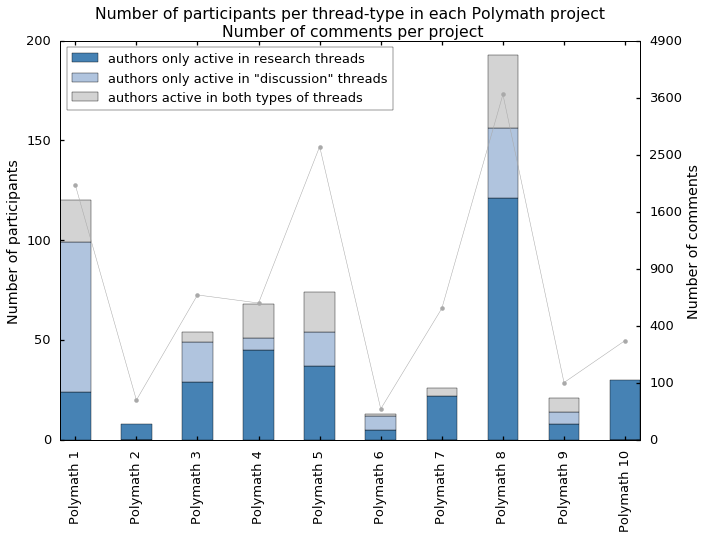

In [16]:
matplotlib.style.use('seaborn-talk')
axes = data.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'],
          title="Number of participants per thread-type in each Polymath project\n Number of comments per project")
axes.set_ylabel("Number of participants")
data2 = np.sqrt(COMMENTS)
axes2 = axes.twinx()
axes2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:"{:0.0f}".format(np.square(x))))
axes2.set_ylabel("Number of comments")
axes2.plot(axes.get_xticks(), data2.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')

### Overview of the mini-projects

In [17]:
PROJECTS_TO_C = ["Mini Polymath {}".format(i) for i in range(1, 5)]
PARTICIPANTS = Series([mPM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([mPM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not mPM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([mPM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))
COMMENTS = Series([mPM_FRAME.loc[project]['number of comments (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['authors only active in research threads'] = df['research threads'] - df['discussion threads']
df['authors only active in "discussion" threads'] = df['discussion threads'] - df['research threads']
df['authors active in both types of threads'] = df['all threads'] - df['authors only active in research threads'] - df['authors only active in "discussion" threads']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['authors only active in research threads']):
        df.loc[project]['authors only active in research threads'] = df.loc[project]['all threads']
data = df[['authors only active in research threads', 'authors only active in "discussion" threads', 'authors active in both types of threads']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)

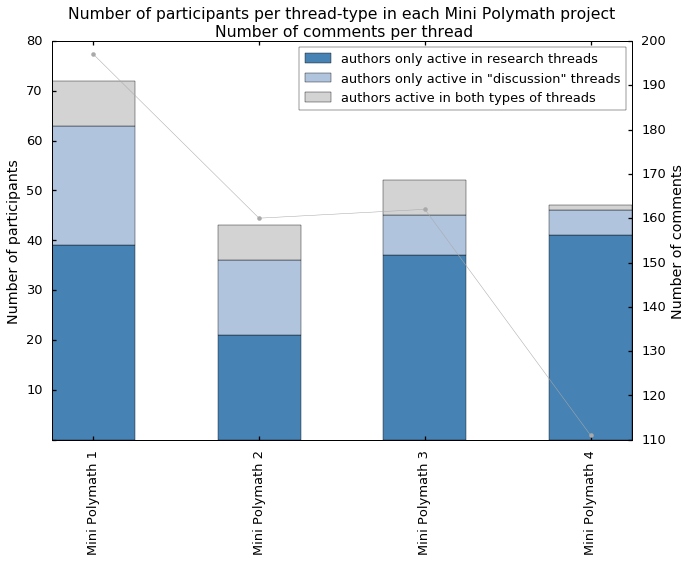

In [18]:
matplotlib.style.use('seaborn-talk')
axes = data.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'],
          title="Number of participants per thread-type in each Mini Polymath project\n Number of comments per thread")
axes.set_ylabel("Number of participants")
axes.yaxis.get_major_ticks()[0].label1.set_visible(False)
data2 = COMMENTS
axes2 = axes.twinx()
axes2.set_ylabel("Number of comments")
axes2.plot(axes.get_xticks(), data2.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')

### Community-evolution

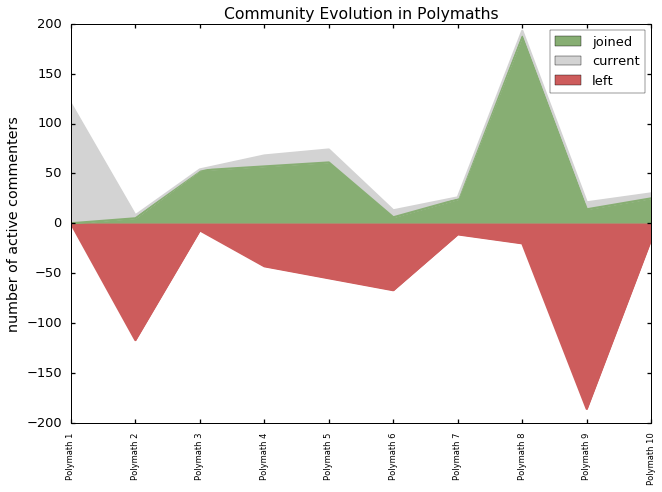

In [19]:
plot_community_evolution("Polymaths")

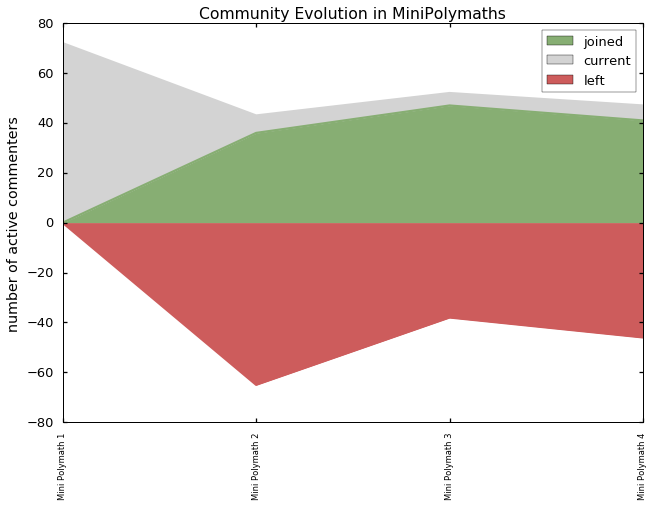

In [20]:
plot_community_evolution("MiniPolymaths")

### Who stays, who leaves

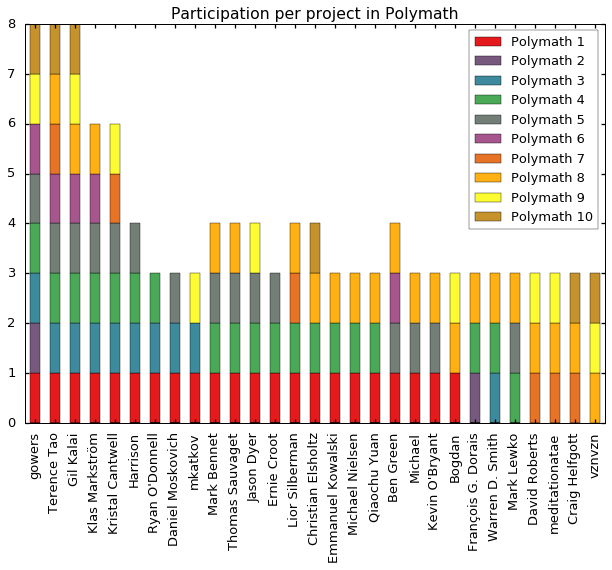

In [21]:
plot_participation_evolution("Polymath", n=3)

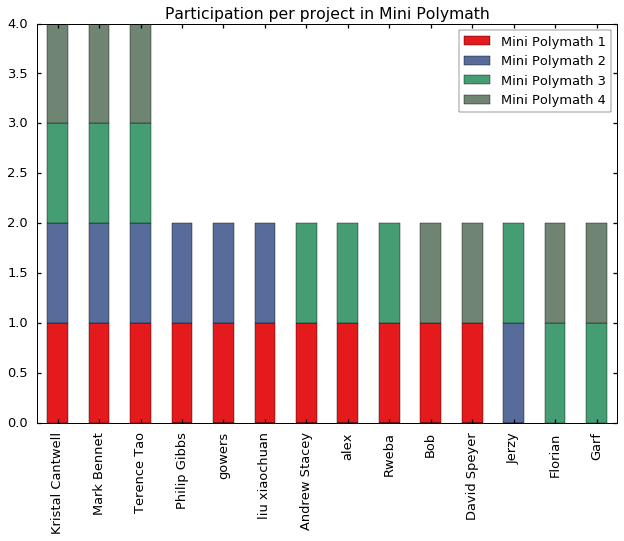

In [22]:
plot_participation_evolution("Mini Polymath", n=2)

### Some specific insights

#### Polymath 1 was *special*

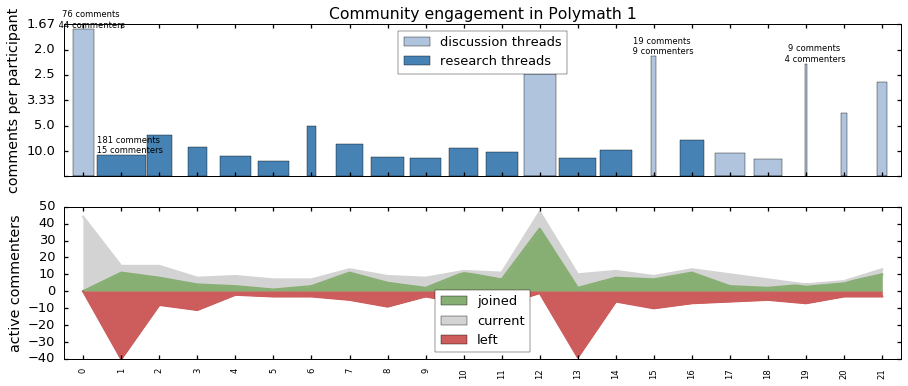

In [23]:
plot_thread_evolution("Polymath 1", compress=140, sel=[0, 1, 15, 19], sharex=True)

### Small and large projects are successful

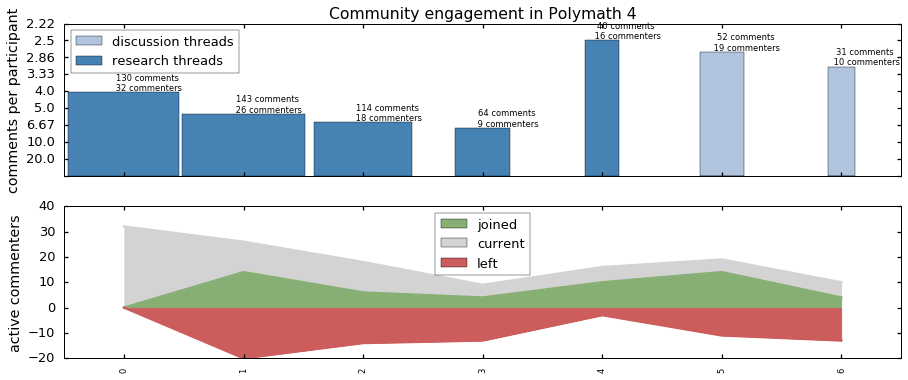

In [24]:
plot_thread_evolution("Polymath 4", compress=140, sel=[0, 1, 2, 3, 4, 5, 6], sharex=True)

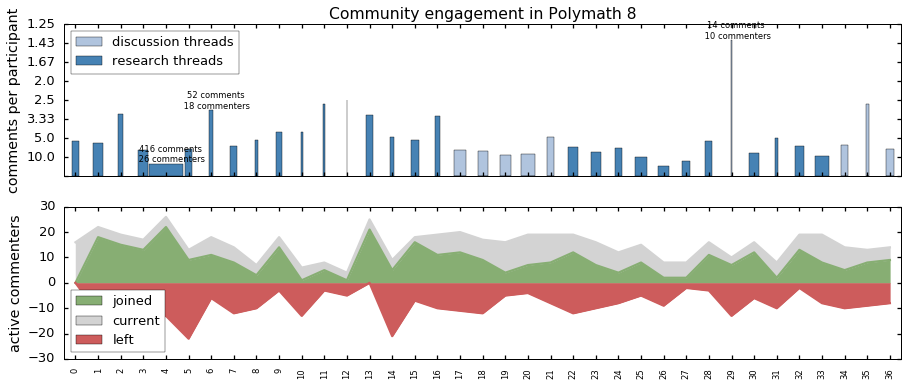

In [25]:
plot_thread_evolution("Polymath 8", compress=280, sel=[4, 6, 29], sharex=True)

### Roles and changes over time

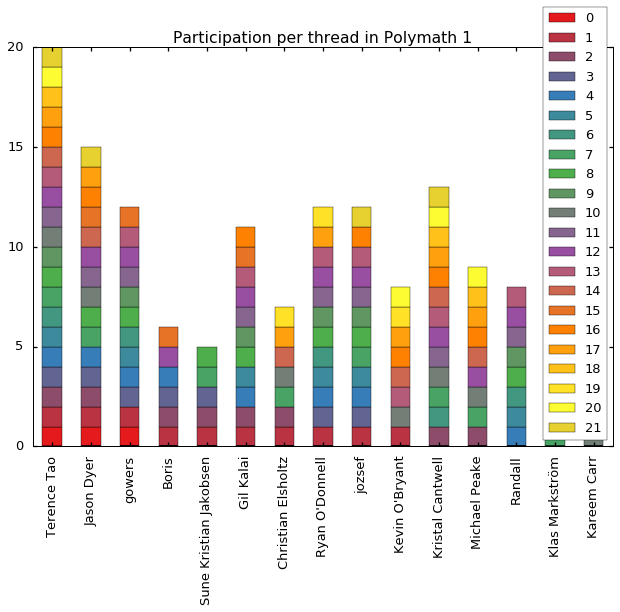

In [26]:
plot_participation_evolution("Polymath 1", n=5)

## Typologies of social communities

### Graph-based typologies
+ Which structures of communities are successful under which circumstances.
+ Two communities are different if their DiGraph are different.
+ Typical results: Maximal information-flow is not optimal.

### A typology based on announcement-types

+ Who can address which sub-groups?

+ Who can make public announcements?

+ Account for higher-order information.

+ Better suited to explain team-work:
    + Mutual intentions
    + Common intentions
    + Group commitments

### Insights from social network analysis

+ Affiliation and interaction-networks

+ Measures of degree-centrality

### Applied to Polymath

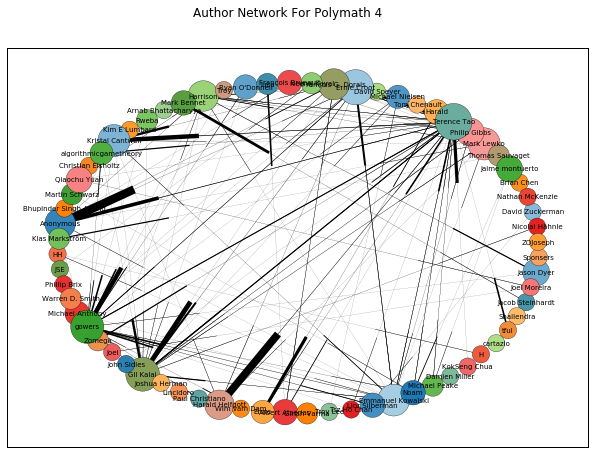

In [27]:
draw_network("Polymath 4")

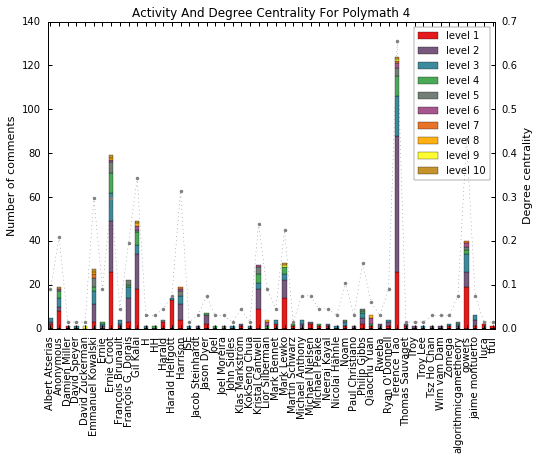

In [28]:
plot_activity_degree("Polymath 4")

## Teamwork versus asynchronous communication

+ Teamwork requires common information

+ But asynchronous communication gets in the way

### Who's in the centre?

`Show in terminal`

## What lies ahead

### Several presentations
+ TOCAI-seminar at Middlesex London (next week).
+ IACAP (submitted).
+ ...

### Issues and experimental features
+ "Implicit" references to other comments
+ Natural language analysis and clustering

### Develop the link with sociological aspect
+ Link with e-research and citizen-science.
+ Logic as a tool in computational social science.

### Articles